## 0. Introduction 
Turk, M. and Pentland, A., 1991. Eigenfaces for recognition. *Journal of cognitive neuroscience*, 3(1), pp.71-86.

In [24]:
from torch import pca_lowrank
from sklearn.model_selection import train_test_split
from sklearn import datasets
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import cv2

import torch
from sklearn.metrics import accuracy_score
from statistics import mode

We will use the [Olivetti faces dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) from AT&T.

The dataset consists of 400, 64 x 64 grey-scale images. We will split this in train and test sets, where 75\% is used in the training and the remaining in the test set.

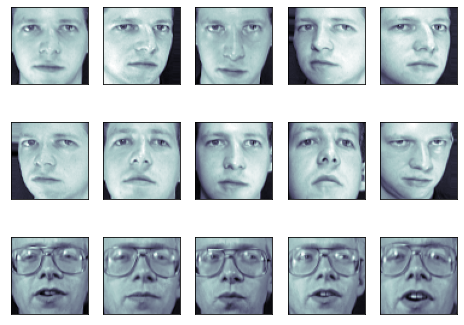

In [25]:
faces = datasets.fetch_olivetti_faces()
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    faces.data, 
    faces.target, 
    random_state=0
    )

print(X_train.shape, X_test.shape)

(300, 4096) (100, 4096)


## 1. Face Recognition using Eigenfaces

Task 1: Construct the mean image and the covariance matrix of the training image set.

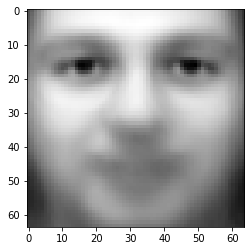

In [28]:
### YOUR CODE 
# calculate the mean face of the train set
# calculate the covariance matrix
# display the mean face (hint: you will need to reshape the mean)
mean_image = X_train.mean(axis=0)
cov_matrix = np.cov(X_train - mean_image)

mean_image_reshaped = mean_image.reshape(64, -1)
plt.imshow(mean_image_reshaped, cmap='gray')
plt.imsave("mean_image.png", mean_image_reshaped, cmap='gray')

Recall from the lectures, to solve PCA we need the eigenvectors of
the covariance matrix so that: $[U,V]=eig(X,X.T)$. However, faster convergence is achieved without using explicit covariance so:  $[U,S,V]=svd(X)$

where:
* $U$ is a $m \times q$ matrix
* $S$ is a $q$ vector
* $V$ is a $n \times q$ matrix

Pytorch provides a lower level method that allows us to explore $[U, S, V]$ through [pca_lowrank](https://pytorch.org/docs/stable/generated/torch.pca_lowrank.html)

Task 2: Compute the eigenfaces of the training set, using [pca_lowrank](https://pytorch.org/docs/stable/generated/torch.pca_lowrank.html). Display the 20 first eigenfaces


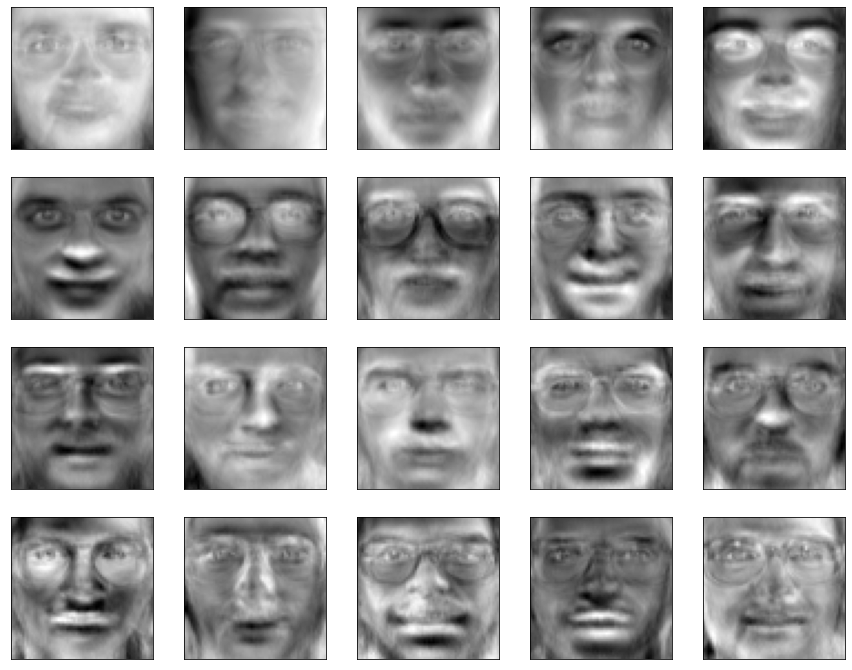

In [31]:
### YOUR CODE HERE
# You will have to reshape the components to display them.
A = X_train - mean_image
result = pca_lowrank(torch.tensor(A), 100)
eigenfaces = result[2]

fig = plt.figure(figsize=(15, 12))
eigenfaces_transpose = eigenfaces.T
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    face = np.array(eigenfaces_transpose[i].reshape(64, -1))
    ax.imshow(face, cmap='gray')
fig.savefig("first_20_eigenfaces")

$A$ is a data matrix with m samples and n features

$V$ columns represent the principal directions

$S^2 / (m - 1)$ contains the eigenvalues of $A.T * A / (m - 1)$

`matmul(A, V[:, :k])` projects data to the first k principal components.

Task 3:  Project both training images and testing images onto the first 20 eigenfaces. 

Compute the distance from the projected test images to the projected training images. 


Display the top 6 best matched training images for the first 6 test images. 

Compute the recognition rate using 20 eigenfaces (predicted class is the class of the nearest training set image). 

Investigate the effect of using different number of eigenfaces for recognition (e.g. plot the recognition rate against the number of eigenfaces).

In [32]:
### YOUR CODE HERE
# Step 1: Project all images onto the first 20 eigenfaces. 
#     Hint: this is regulated by the number of components
train_projection = np.matmul(X_train - mean_image, eigenfaces[:, :20])
test_projection = np.matmul(X_test - mean_image, eigenfaces[:, :20])

In [35]:
# Step 2: Compute the distance from the projected test images to the projected 
# training . 

def euclidean_distance(v1, v2):
  d = 0
  ### fill in the method
  d = (v1 - v2) ** 2
  d = np.sqrt(d.sum())
  return d

# Find the distance between test and training projections
distance = []

for row in test_projection:
  current = []
  for col in train_projection:
    col_dist = euclidean_distance(row, col)
    current.append(col_dist)
  distance.append(current)

distance = np.array(distance)

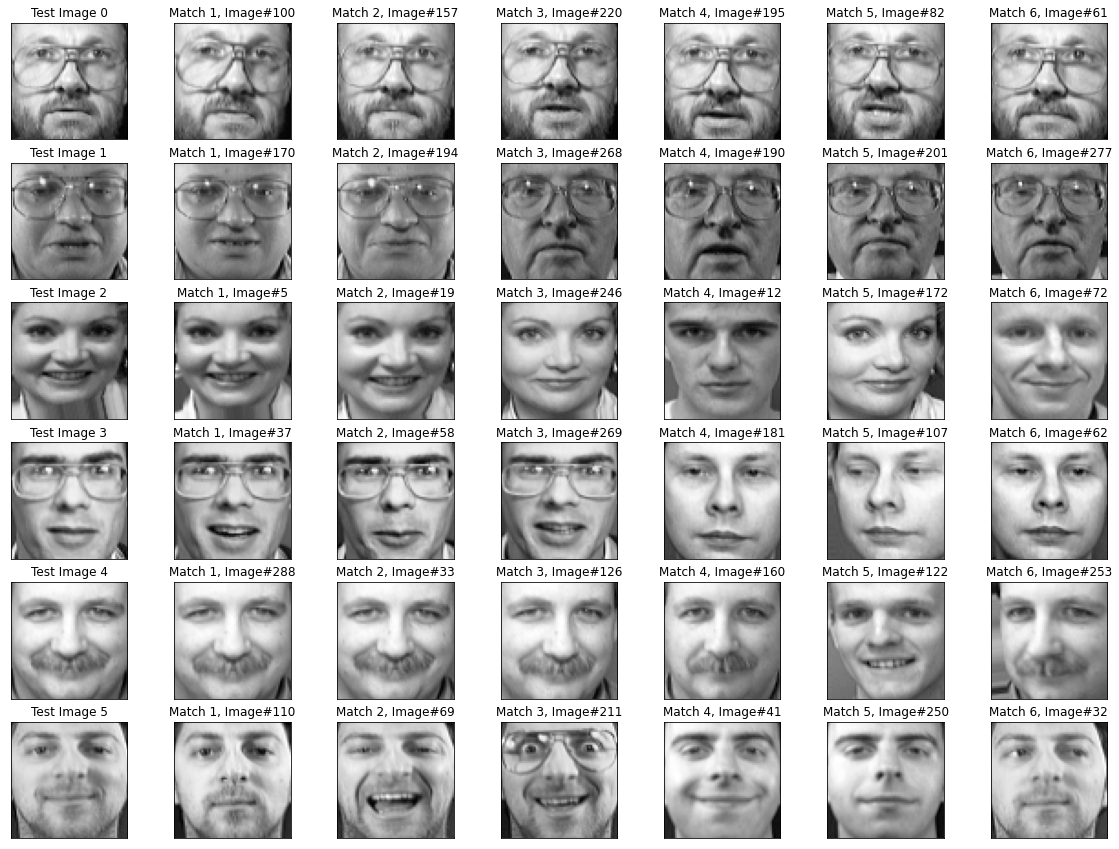

In [36]:
# Step 3: Display the top 6 best matched images for the first 6 test images
test_image_with_matches = []

fig = plt.figure(figsize=(20, 15))

for i in range(6):
  current = distance[i]
  first_six = np.argsort(current)[:6]

  test_image = [X_test[i]]
  matches = X_train[(first_six)]
  test_image_with_matches = np.concatenate((test_image, matches))
  test_image_with_matches = np.array(test_image_with_matches).reshape((7, 64, -1))

  for j in range(1, 8):
    ax_index = (7*i)+j # 1...42
    ax = fig.add_subplot(6, 7, ax_index, xticks=[], yticks=[])
    face = test_image_with_matches[j-1]
    ax.imshow(face, cmap='gray')
    if (j==1):
      ax.set_title("Test Image {}".format(i))
    else:
      ax.set_title("Match {}, Image#{}".format(j-1, first_six[j-2]))

fig.savefig("first_6_test_images_with_top_6_matches")

In [37]:
# Step 4: Assign a class to each image on the test set (class of test image is 
# the class of it's nearest neighbour in the train set)
# and calculate the recognition rate
y_pred = np.zeros(100, dtype=int)

for i, faces in enumerate(distance):
  min_idx = np.argmin(faces)
  y_pred[i] = y_train[min_idx]

recognition_rate = accuracy_score(y_test, y_pred, normalize=False)
print("Recognition rate is {}%".format(recognition_rate))


Recognition rate is 92%


In [39]:
# Step 5: investigate effect of number of eigenfaces for recognition rate
recognition_rate = []
y_pred = np.zeros(100, dtype=int)

for num in range(1,101):
  train_projection = np.matmul(X_train - mean_image, eigenfaces[:, :num])
  test_projection = np.matmul(X_test - mean_image, eigenfaces[:, :num]) 

  # Find the distance between test and training projections
  distance = []

  for row in test_projection:
    current = []
    for col in train_projection:
      col_dist = euclidean_distance(row, col)
      current.append(col_dist)
    distance.append(current)

  distance = np.array(distance)

  # Assign predicted class to test image based on nearest image in the training set
  for i, faces in enumerate(distance):
    min_idx = np.argmin(faces)
    y_pred[i] = y_train[min_idx]

  accuracy = accuracy_score(y_test, y_pred, normalize=False)
  recognition_rate.append(accuracy)
print(num, "Recognition rate is {}%".format(recognition_rate))

100 Recognition rate is [19, 33, 54, 66, 74, 83, 84, 87, 87, 89, 90, 89, 90, 92, 93, 94, 92, 93, 93, 92, 92, 92, 92, 93, 94, 94, 94, 93, 94, 94, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 96, 96, 96, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 94, 95, 96, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 95, 95, 96, 97, 96, 95, 95, 95, 95, 95, 96, 96, 95, 95, 95, 95, 95, 96, 95, 95, 94, 94, 94, 94, 96]%


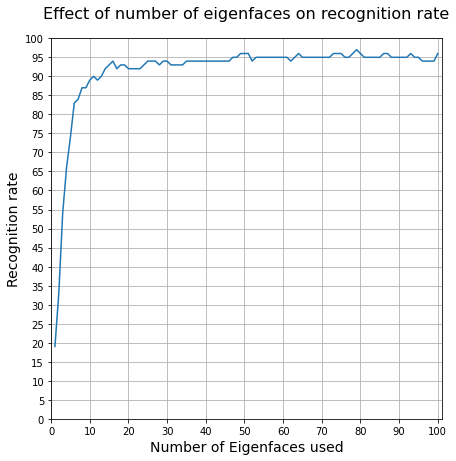

In [40]:
# Plot the recognition rate against the number of eigenfaces
fig, ax = plt.subplots(figsize=(7,7))
x = list(range(1,101))
ax.set_title('Effect of number of eigenfaces on recognition rate', fontsize=16, pad=20.0)
ax.set_xlabel('Number of Eigenfaces used', fontsize=14)
ax.set_ylabel('Recognition rate', fontsize=14)
ax.axis([0, 101, 0, 100])
ax.set_yticks(np.arange(0,101,5))
ax.set_xticks(np.arange(0,101,10))
ax.grid(True)
ax.plot(x, recognition_rate)

Task 4: So far we have implemented a KNN classifier with K=1. Investigate the effect of K in K-Nearest-Neighbour (KNN) classifier. Plot the average recognition rate against K.

In [41]:
### YOUR CODE HERE
# Training and test images have been projected onto the first 29 eigenfaces, 
# where the recognition rate hits 95 percent
recognition_rate_knn = []
train_projection = np.matmul(X_train - mean_image, eigenfaces[:, :29])
test_projection = np.matmul(X_test - mean_image, eigenfaces[:, :29]) 

distance = []
for row in test_projection:
  current = []
  for col in train_projection:
    col_dist = euclidean_distance(row, col)
    current.append(col_dist)
  distance.append(current)
distance = np.array(distance)

for k in range(1,30,2):
  for i, faces in enumerate(distance):
    min_idxs = np.argsort(faces)[:k]
    classes = y_train[min_idxs]
    best_class = mode(classes)
    y_pred[i] = best_class

  accuracy = accuracy_score(y_test, y_pred, normalize=False)
  recognition_rate_knn.append(accuracy)
  print("When K is {} -".format(k),"Recognition rate is {}%".format(accuracy))

When K is 1 - Recognition rate is 94%
When K is 3 - Recognition rate is 89%
When K is 5 - Recognition rate is 87%
When K is 7 - Recognition rate is 82%
When K is 9 - Recognition rate is 80%
When K is 11 - Recognition rate is 74%
When K is 13 - Recognition rate is 73%
When K is 15 - Recognition rate is 71%
When K is 17 - Recognition rate is 68%
When K is 19 - Recognition rate is 68%
When K is 21 - Recognition rate is 67%
When K is 23 - Recognition rate is 66%
When K is 25 - Recognition rate is 65%
When K is 27 - Recognition rate is 61%
When K is 29 - Recognition rate is 60%


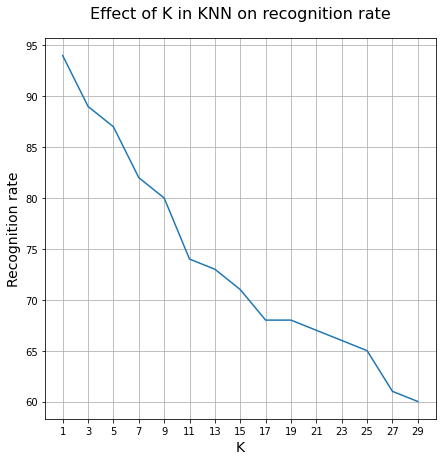

In [42]:
# Plot the recognition rate against K
fig, ax = plt.subplots(figsize=(7,7))
x = list(range(1,30,2))
ax.set_title('Effect of K in KNN on recognition rate', fontsize=16, pad=20.0)
ax.set_xlabel('K', fontsize=14)
ax.set_ylabel('Recognition rate', fontsize=14)
ax.set_xticks(np.arange(1,30,2))
ax.grid(True)
ax.plot(x, recognition_rate_knn)


# ax.axis([0, 30, 50, 100])